In [5]:
pip install geopandas matplotlib

In [6]:
pip install tslearn

In [7]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import geopandas as gpd
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans

In [9]:
def normalise(df):
  scaler = StandardScaler()
  df[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(df[['Emission', 'Fertlizer_consumption', 'Temperature']])
  return df

In [10]:
forecast_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

In [11]:
no2_emission_df = pd.read_csv('/content/drive/MyDrive/final_project/EML_forecast/nitrous-oxide-emissions.csv')

In [12]:
#Dropping unnamed column from  dataframe
forecast_df = forecast_df.drop(columns=['Unnamed: 0'], axis=1)
print(forecast_df)

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [13]:
#Converting Year column to date format
forecast_df['Year'] = pd.to_datetime(forecast_df['Year'], format='%Y')
print(forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704
...         ...          ...        ...                    ...          ...
7864 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878
7865 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628
7866 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425
7867 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597
7868 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [14]:
#Removing all the entries where the Country name is World
world_df = forecast_df[forecast_df['Country']=='World']
print(world_df)

           Year Country      Emission  Fertlizer_consumption  Temperature
7625 1961-01-01   World  1.306421e+09                   7.54    13.834331
7626 1962-01-01   World  1.351320e+09                   8.49    13.773776
7627 1963-01-01   World  1.395579e+09                   9.59    13.810771
7628 1964-01-01   World  1.445608e+09                  10.79    13.598830
7629 1965-01-01   World  1.502395e+09                  12.46    13.660751
...         ...     ...           ...                    ...          ...
7681 2017-01-01   World  2.869500e+09                  66.87    14.715000
7682 2018-01-01   World  2.865544e+09                  66.06    14.635236
7683 2019-01-01   World  2.852601e+09                  63.71    14.770584
7684 2020-01-01   World  2.901733e+09                  66.90    14.803519
7685 2021-01-01   World  2.943274e+09                  65.45    14.645046

[61 rows x 5 columns]


In [15]:
#Normalising data using MinMaxScaler and creating a new normalised datafraame
scaler = StandardScaler()
corr_df_norm = pd.DataFrame(scaler.fit_transform(world_df[['Emission', 'Fertlizer_consumption', 'Temperature']]), columns = ['Emission', 'Fertlizer_consumption', 'Temperature'])
print(corr_df_norm)

    Emission  Fertlizer_consumption  Temperature
0  -2.142209              -2.049221    -0.847766
1  -2.037458              -1.995953    -1.028093
2  -1.934198              -1.934273    -0.917926
3  -1.817477              -1.866986    -1.549060
4  -1.684989              -1.773345    -1.364667
..       ...                    ...          ...
56  1.504553               1.277562     1.774755
57  1.495322               1.232143     1.537228
58  1.465126               1.100373     1.940278
59  1.579755               1.279244     2.038354
60  1.676672               1.197939     1.566441

[61 rows x 3 columns]


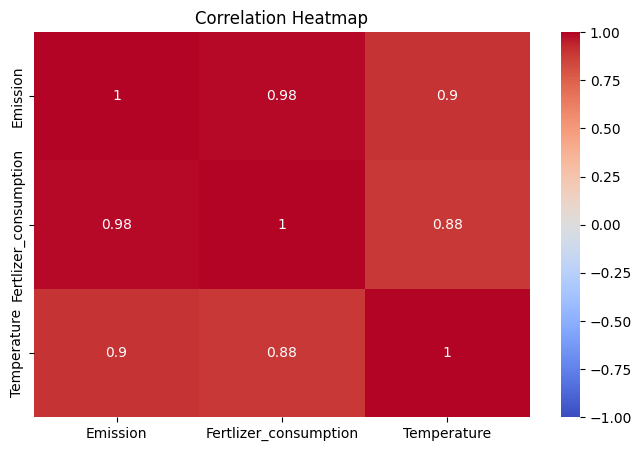

In [16]:
#Creating a correlation heatmap to explain the correlation between variables
corr_matrix = corr_df_norm.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

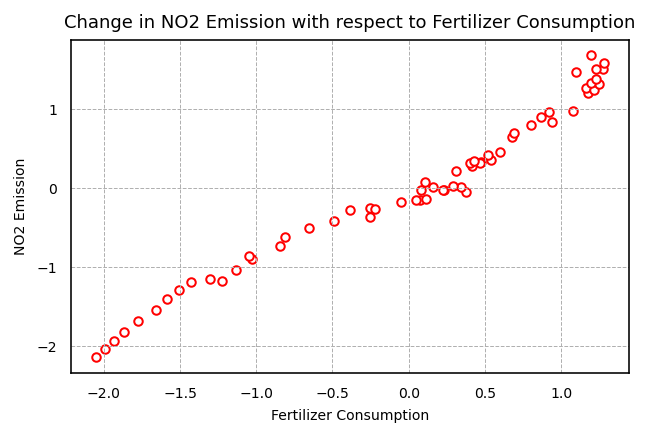

In [17]:
#Creating a scatter plot to show the correlation between Nitrous oxide emission
#and Fertilizer consumption
plt.figure(dpi=144 ,figsize=(5,3))
plt.scatter(x=corr_df_norm['Fertlizer_consumption'], y=corr_df_norm['Emission'],
            s=18, facecolor='white', edgecolor='red')
plt.xlabel("Fertilizer Consumption", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.title("Change in NO2 Emission with respect to Fertilizer Consumption", fontsize=9)
plt.show()

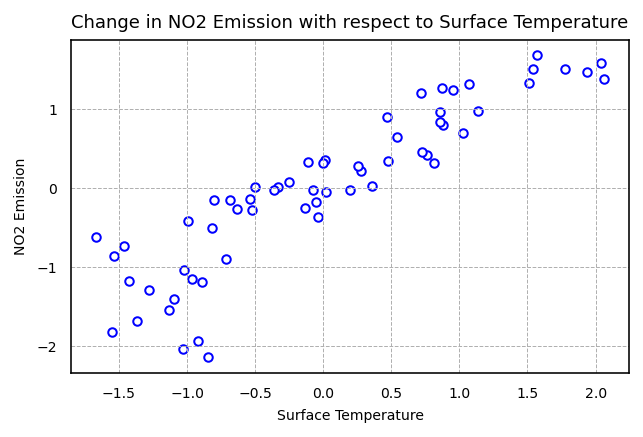

In [18]:
#Plotting a scatter plot to show the correlation between Nitrous Oxide emission
#and temperature
plt.figure(dpi=144, figsize=(5,3))
plt.scatter(x=corr_df_norm['Temperature'], y=corr_df_norm['Emission'],
            s=18, facecolor='white', edgecolor='blue')
plt.xlabel("Surface Temperature", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.title("Change in NO2 Emission with respect to Surface Temperature", fontsize=9)
plt.show()

In [19]:
cluster_df = forecast_df[forecast_df['Country']!="World"]

In [20]:
#Normalising the values of Cluster_df using standard scaler
norm_cluster_df= cluster_df.groupby("Country").apply(lambda x:normalise(x)).reset_index(drop=True)

In [21]:
print(norm_cluster_df)

           Year      Country  Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan -0.712272              -1.105319    -0.917338
1    1962-01-01  Afghanistan -0.751117              -1.105319    -1.135850
2    1963-01-01  Afghanistan -0.676183              -1.105319     0.309998
3    1964-01-01  Afghanistan -0.582949              -1.105319    -1.953138
4    1965-01-01  Afghanistan -0.476538              -1.105319    -1.058171
...         ...          ...       ...                    ...          ...
7803 2017-01-01     Zimbabwe  0.400771              -0.624780     0.032740
7804 2018-01-01     Zimbabwe  0.503282              -1.094862     1.164540
7805 2019-01-01     Zimbabwe  0.403417              -1.094862     2.037056
7806 2020-01-01     Zimbabwe -0.120035              -1.435445     0.958329
7807 2021-01-01     Zimbabwe  0.195951              -1.435445     0.605094

[7808 rows x 5 columns]


In [22]:
pivot_cluster_df = norm_cluster_df.pivot(index="Year", columns = "Country", values='Emission')

In [23]:
print(pivot_cluster_df)

Country     Afghanistan   Albania   Algeria    Angola  Argentina  Australia  \
Year                                                                          
1961-01-01    -0.712272 -1.880740 -1.543655 -1.154992  -1.542932  -1.188309   
1962-01-01    -0.751117 -1.863443 -1.508476 -1.142133  -1.598983  -1.067309   
1963-01-01    -0.676183 -1.898035 -1.558351 -1.132957  -1.775032  -0.995242   
1964-01-01    -0.582949 -1.852313 -1.543670 -1.112961  -1.516060  -0.879565   
1965-01-01    -0.476538 -1.661071 -1.435603 -1.092478  -1.206775  -0.825380   
...                 ...       ...       ...       ...        ...        ...   
2017-01-01     2.226094  0.396366  1.738142  1.326149   1.907856   0.852372   
2018-01-01     2.083739 -0.100591  1.814894  0.897106   1.762360   0.709590   
2019-01-01     1.766261  0.003037  1.860995  1.369345   2.125832  -0.470699   
2020-01-01     1.655276 -0.432531  1.710426  1.178681   2.348955  -1.369867   
2021-01-01     1.426868 -1.445299  1.737075  1.22495

In [24]:
reshaped_cluster_df = pivot_cluster_df.values.transpose()

In [25]:
print(reshaped_cluster_df)

[[-0.71227186 -0.75111729 -0.67618297 ...  1.76626108  1.65527594
   1.42686805]
 [-1.88073985 -1.86344332 -1.8980351  ...  0.00303686 -0.43253067
  -1.44529941]
 [-1.54365522 -1.5084756  -1.55835111 ...  1.86099502  1.71042596
   1.73707476]
 ...
 [-1.0985256  -1.0844603  -1.07029572 ...  1.56248471  1.49020692
   1.50278872]
 [-1.28602415 -1.27712965 -1.26007646 ...  1.42807787  1.29734245
   1.2758825 ]
 [-2.24099304 -2.21743626 -2.16021198 ...  0.40341728 -0.12003472
   0.19595058]]


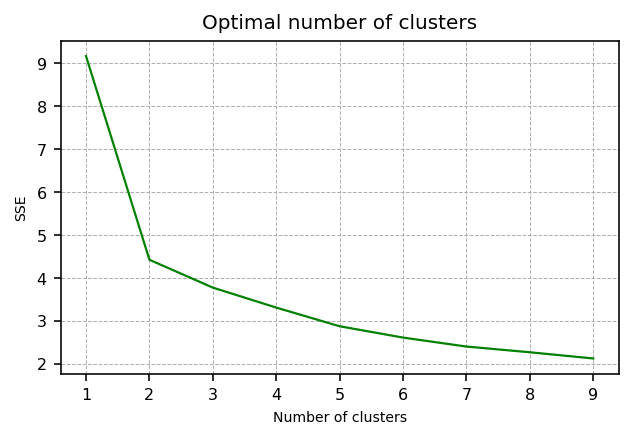

In [26]:
#Calculating the optimal number of clusters using elbow method
sse = []
for i in range(1,10):
  model = TimeSeriesKMeans(n_clusters=i,metric="dtw", random_state=42,init="k-means++", n_init=10)
  model.fit(reshaped_cluster_df)
  sse.append(model.inertia_)

plt.figure(dpi=144, figsize=(5,3))
plt.plot(range(1,10), sse, linewidth=1.1, c="green")
plt.xlabel("Number of clusters", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.ylabel("SSE", fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Optimal number of clusters", fontsize=10)
plt.show()

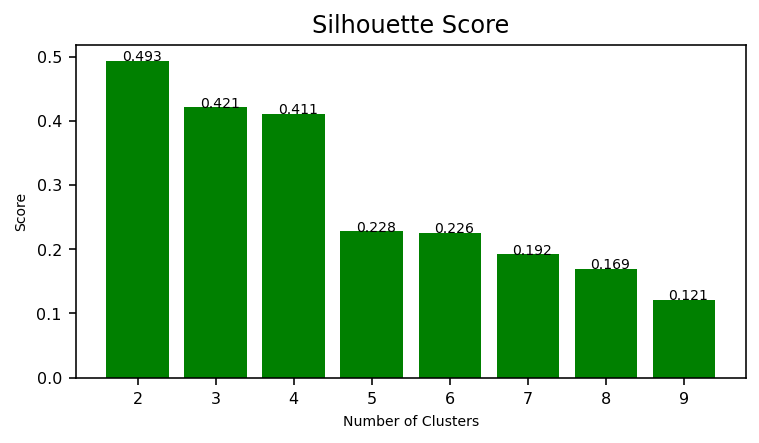

In [27]:
#Calcualating Silhouette score to find the optimal number of clusters
def add_label(x, y):
  # A function to add labels inside a plot
  for i in range (len(x)):
    plt.text(i+1.8, y[i], round(y[i], 3), fontsize=7)
s_score = []
for i in range(2,10):
  model = TimeSeriesKMeans(n_clusters=i,metric="dtw", random_state=42,init="k-means++", n_init=10)
  labels = model.fit_predict(reshaped_cluster_df)
  s_avg = silhouette_score(reshaped_cluster_df, labels)
  s_score.append(s_avg)
plt.figure(dpi=144, figsize=(6,3))
plt.bar(range(2,10), s_score, color='green')
add_label(range(2,10), s_score)
plt.xlabel("Number of Clusters", fontsize=7)
plt.ylabel("Score", fontsize=7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Silhouette Score")
plt.show()


In [28]:
#Applying KMeans clustering algorithm with number of clusters equal to 3
model = TimeSeriesKMeans(n_clusters=2,metric="dtw", random_state=42,init="k-means++", n_init=10)
labels = model.fit_predict(reshaped_cluster_df)

# Create a dataframe with cluster labels
country_labels = pd.DataFrame({'Country': norm_cluster_df['Country'].unique(), 'Cluster': labels})

In [29]:
#Merging the actual forecast_df with country_labels by Country column
cluster_forecast_df = pd.merge(forecast_df, country_labels, on=('Country'))
print(cluster_forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature  \
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   
...         ...          ...        ...                    ...          ...   
7803 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878   
7804 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628   
7805 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425   
7806 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597   
7807 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135   

      Cluster  
0           0  
1           0  
2  

In [30]:
#Ctreating the new dataframe with the newly clustered daatframe by Country and Cluster
cluster_grouped_df = cluster_forecast_df.groupby(['Country', 'Cluster'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster_grouped_df = cluster_grouped_df.reset_index()


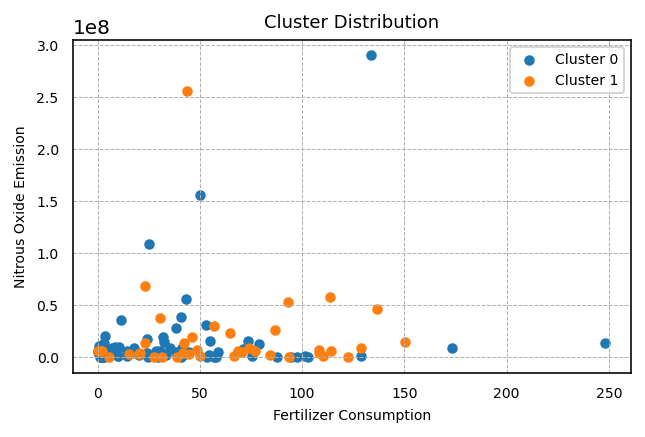

In [31]:
#Plotting the scatter plot to show the cluster distribution
plt.figure(dpi=144, figsize=(5,3))
plt.scatter(x=cluster_grouped_df[cluster_grouped_df["Cluster"]==0]['Fertlizer_consumption'],
            y=cluster_grouped_df[cluster_grouped_df["Cluster"]==0]['Emission'],
            label="Cluster 0", s=18)
plt.scatter(x=cluster_grouped_df[cluster_grouped_df["Cluster"]==1]['Fertlizer_consumption'],
            y=cluster_grouped_df[cluster_grouped_df["Cluster"]==1]['Emission'],
            label="Cluster 1", s=18)
plt.legend(fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Fertilizer Consumption", fontsize=7)
plt.ylabel("Nitrous Oxide Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Cluster Distribution", fontsize=9)
plt.show()

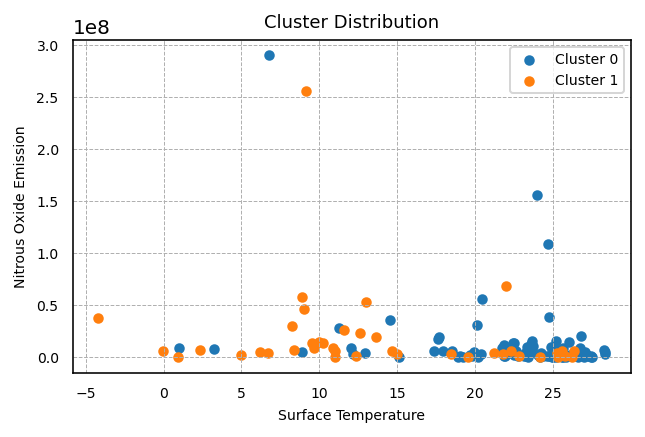

In [32]:
#Plotting the scatter plot to show the cluster distribution
plt.figure(dpi=144, figsize=(5,3))
plt.scatter(x=cluster_grouped_df[cluster_grouped_df["Cluster"]==0]['Temperature'],
            y=cluster_grouped_df[cluster_grouped_df["Cluster"]==0]['Emission'],
            label="Cluster 0", s=18)
plt.scatter(x=cluster_grouped_df[cluster_grouped_df["Cluster"]==1]['Temperature'],
            y=cluster_grouped_df[cluster_grouped_df["Cluster"]==1]['Emission'],
            label="Cluster 1", s=18)
plt.legend(fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(left=False, bottom=False)
plt.xlabel("Surface Temperature", fontsize=7)
plt.ylabel("Nitrous Oxide Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Cluster Distribution", fontsize=9)
plt.show()

In [33]:
cluster_grouped_df = cluster_grouped_df.reset_index()

In [34]:
#Creating seperate dataframe for each of the clusters
cluster0_df = cluster_forecast_df[cluster_forecast_df['Cluster']==0]
cluster1_df = cluster_forecast_df[cluster_forecast_df['Cluster']==1]


In [35]:
#Grouping each of the cluster dataframe by Year
cluster0_grouped_df = cluster0_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster1_grouped_df = cluster1_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()



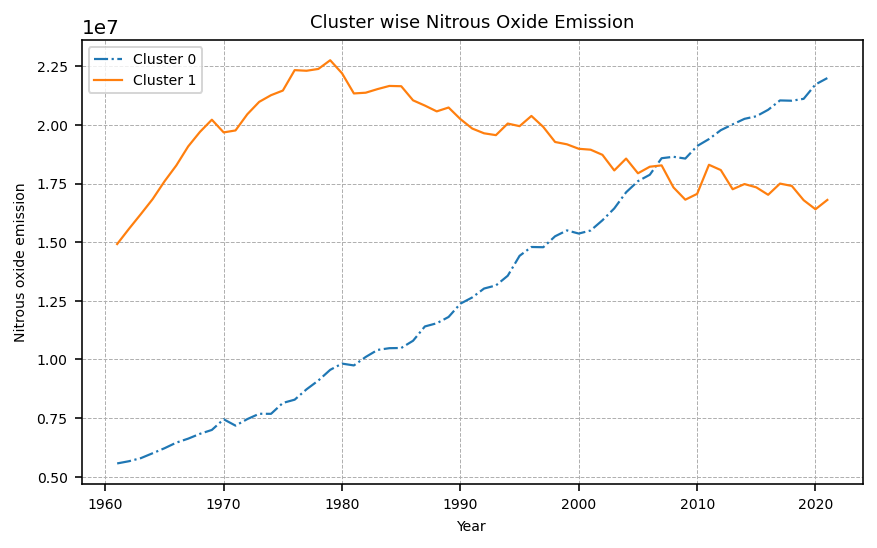

In [36]:
#Creating a line plot to show the trend in nitrous oxide Emission for each cluster
#over the years
plt.figure(dpi=144, figsize=(7,4))
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Emission'],
         label='Cluster 0', linewidth = 1.1, linestyle='-.')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Emission'],
         label='Cluster 1', linewidth = 1.1, linestyle='-')

plt.xlabel("Year", fontsize=7)
plt.ylabel("Nitrous oxide emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.title("Cluster wise Nitrous Oxide Emission", fontsize=9)
plt.show()

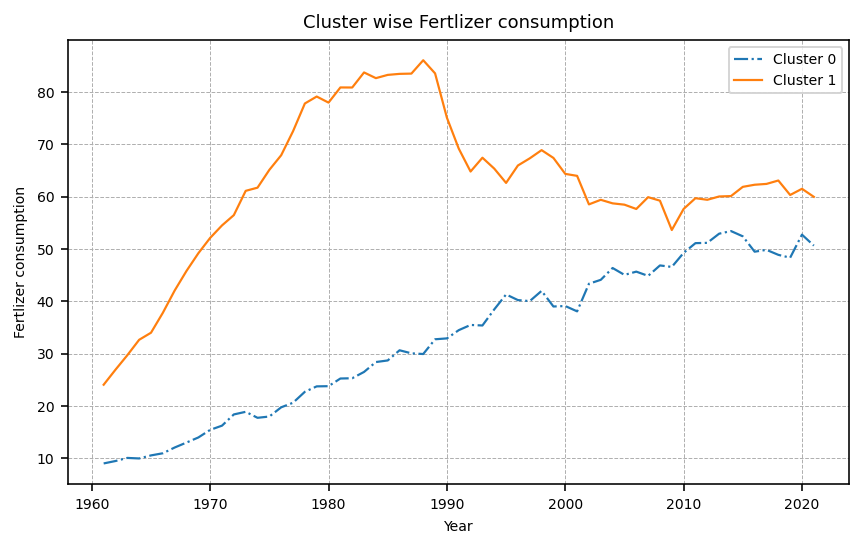

In [37]:
#Creating a lineplot to show the trend in Fertilizer Consumption for each cluster
#over the years
plt.figure(dpi=144, figsize=(7,4))
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Fertlizer_consumption'],
         label='Cluster 0', linewidth = 1.1, linestyle='-.')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Fertlizer_consumption'],
         label='Cluster 1', linewidth = 1.1, linestyle='-')
plt.xlabel("Year", fontsize=7)
plt.ylabel("Fertlizer consumption", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.title("Cluster wise Fertlizer consumption", fontsize=9)
plt.show()

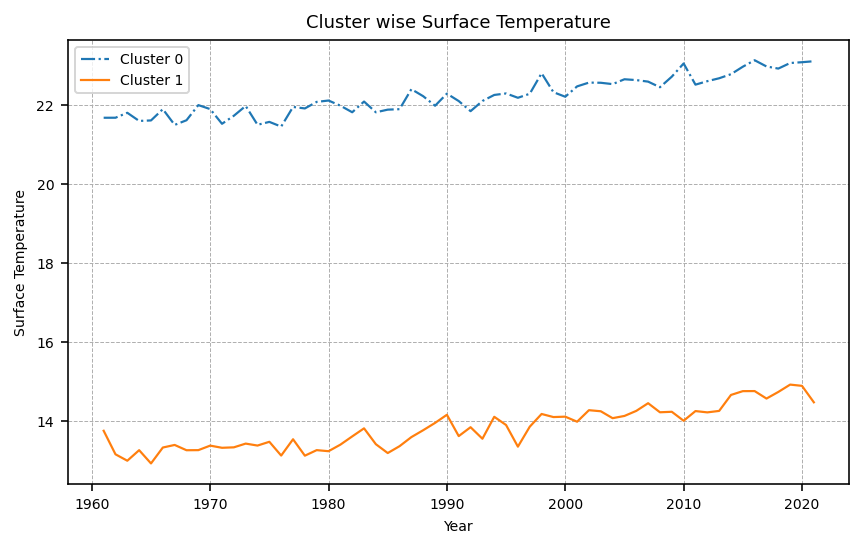

In [38]:
#Creating a line plot to show the trend in surface temperature for each cluster
#over the years
plt.figure(dpi=144, figsize=(7,4))
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Temperature'],
         label='Cluster 0', linewidth = 1.1, linestyle='-.')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Temperature'],
         label='Cluster 1', linewidth = 1.1, linestyle='-')
plt.xlabel("Year", fontsize=7)
plt.ylabel("Surface Temperature", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(fontsize=7)
plt.title("Cluster wise Surface Temperature", fontsize=9)
plt.show()

In [39]:
print(country_labels[country_labels['Country'] == "United States"])

           Country  Cluster
121  United States        1


In [40]:
country_labels['Country'] = country_labels['Country'].replace("United States", "United States of America")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged = world.set_index('name').join(country_labels.set_index('Country'))


<ipython-input-40-dc22906f1cf9>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


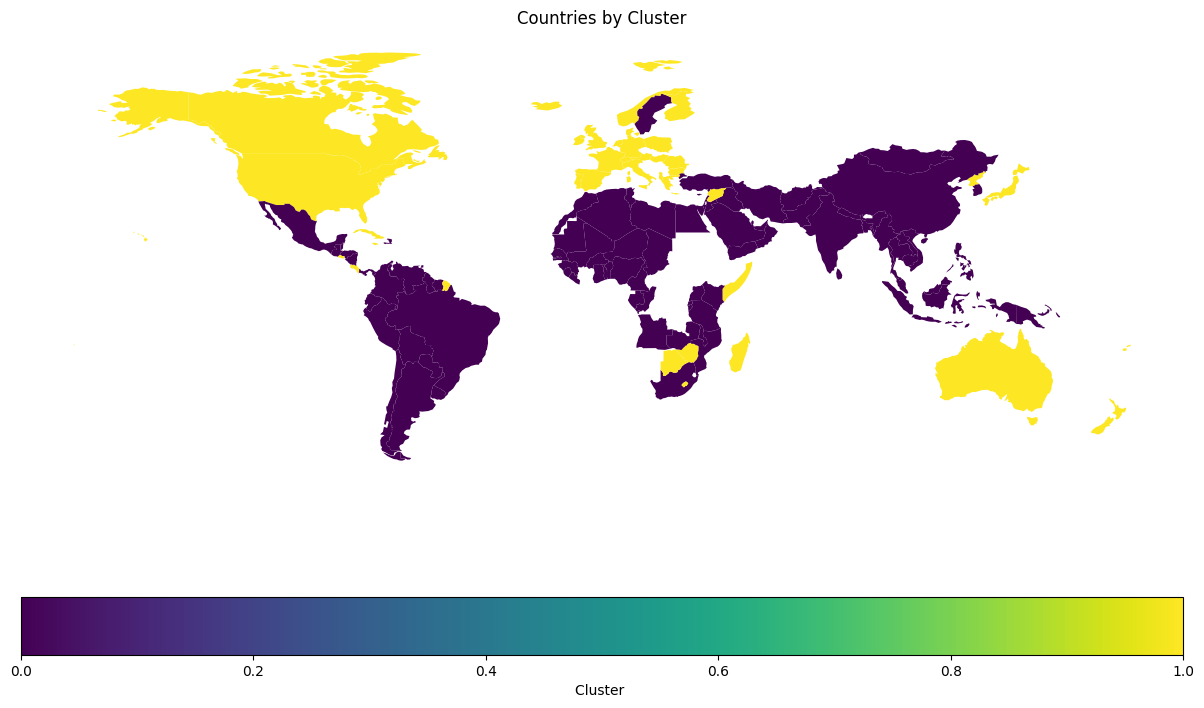

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='Cluster', ax=ax, legend=True, legend_kwds={'label': "Cluster ", 'orientation': "horizontal"})
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title('Countries by Cluster')
plt.show()

In [43]:
cluster0_df_norm = cluster0_df.groupby("Country").apply(lambda x : normalise(x))
cluster1_df_norm = cluster1_df.groupby("Country").apply(lambda x : normalise(x))

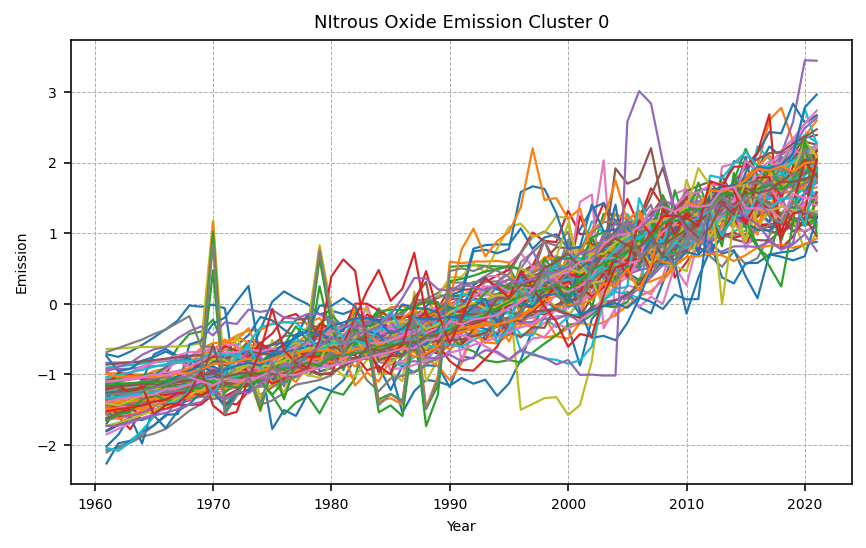

In [58]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster0_df_norm['Country'].unique():
  cluster_country = cluster0_df_norm[cluster0_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Emission'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NItrous Oxide Emission - Cluster 0", fontsize=9)
plt.show()

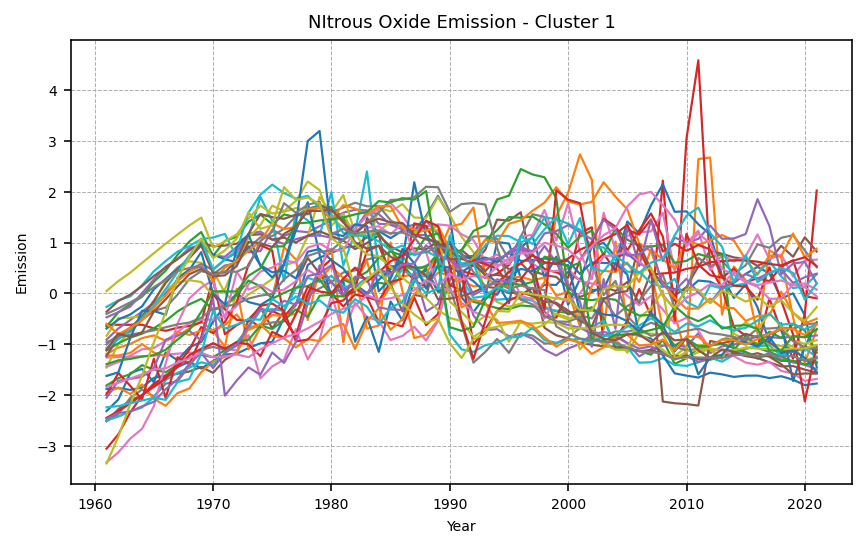

In [57]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster1_df_norm['Country'].unique():
  cluster_country = cluster1_df_norm[cluster1_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Emission'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NItrous Oxide Emission - Cluster 1", fontsize=9)
plt.show()

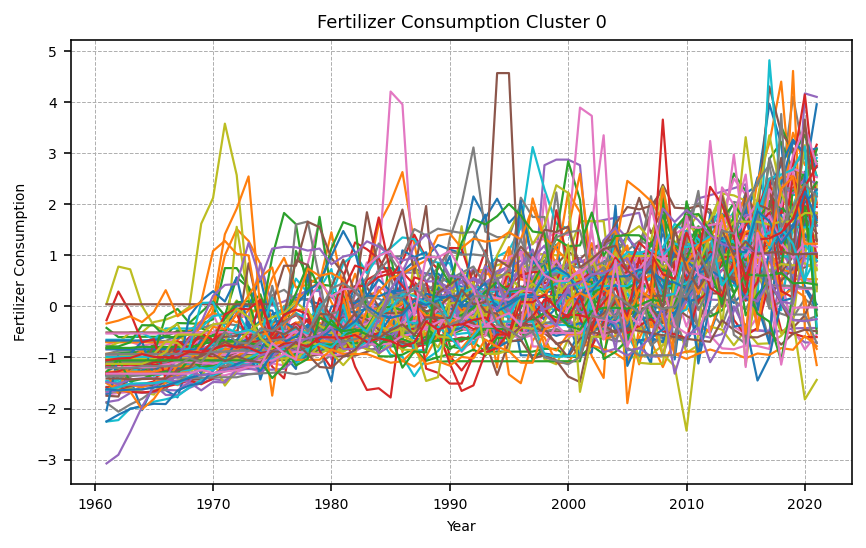

In [56]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster0_df_norm['Country'].unique():
  cluster_country = cluster0_df_norm[cluster0_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Fertlizer_consumption'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Fertilizer Consumption", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Fertilizer Consumption - Cluster 0", fontsize=9)
plt.show()

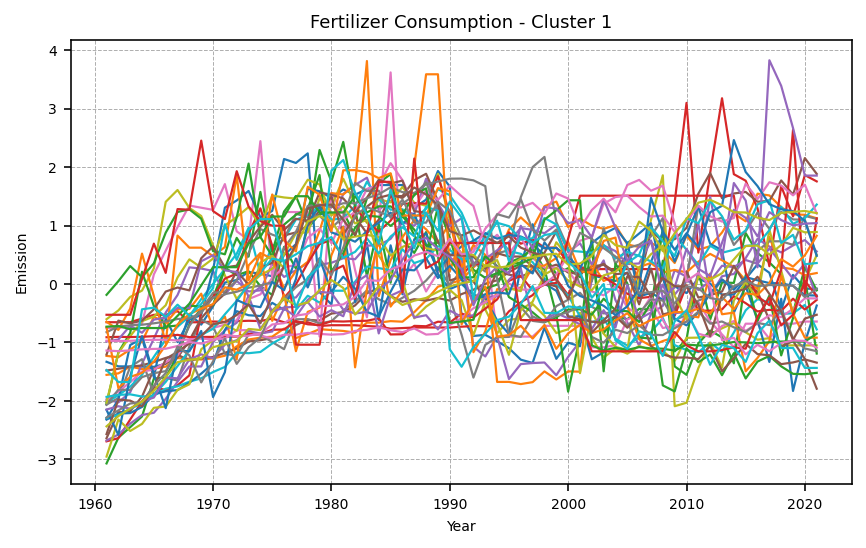

In [55]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster1_df_norm['Country'].unique():
  cluster_country = cluster1_df_norm[cluster1_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Fertlizer_consumption'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Fertilizer Consumption - Cluster 1", fontsize=9)
plt.show()

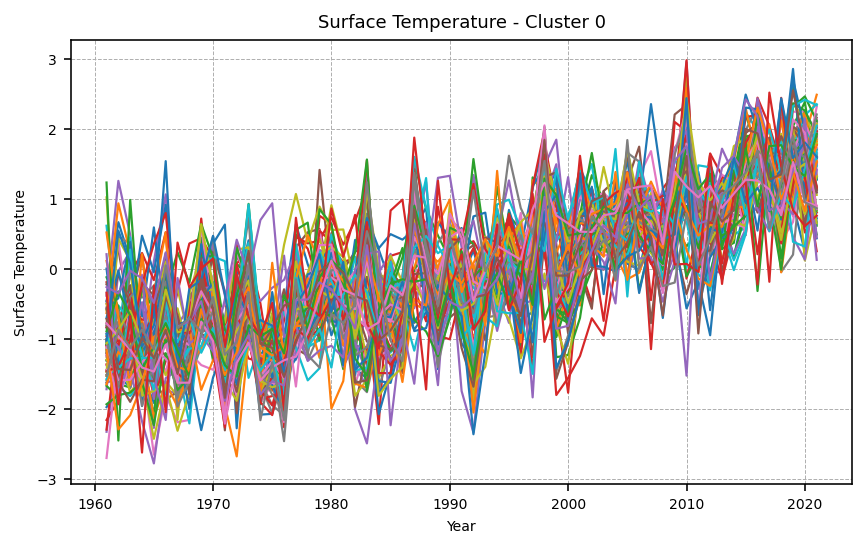

In [54]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster0_df_norm['Country'].unique():
  cluster_country = cluster0_df_norm[cluster0_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Temperature'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Surface Temperature", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Surface Temperature - Cluster 0", fontsize=9)
plt.show()


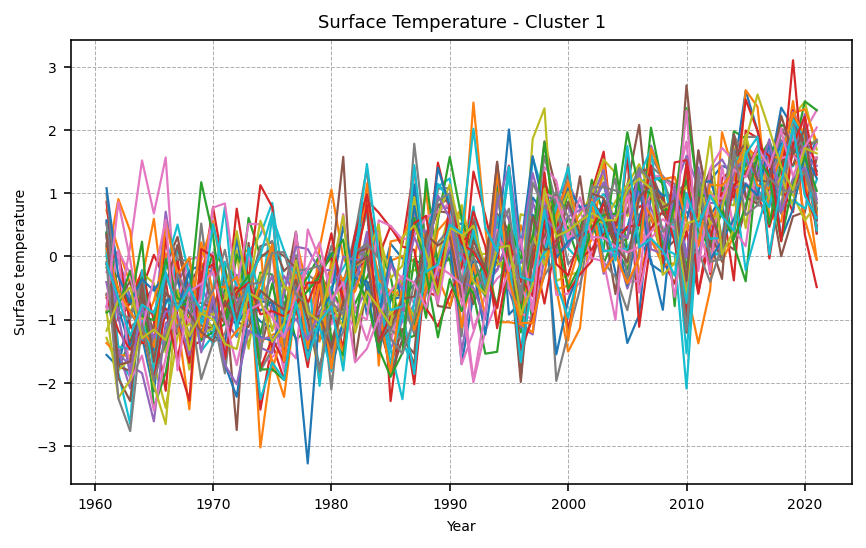

In [53]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster1_df_norm['Country'].unique():
  cluster_country = cluster1_df_norm[cluster1_df_norm['Country']==country]
  plt.plot(cluster_country["Year"], cluster_country['Temperature'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("Surface temperature", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("Surface Temperature - Cluster 1", fontsize=9)
plt.show()

In [66]:
cluster0_country_grouped = cluster0_df.groupby("Country")[['Emission', 'Fertlizer_consumption', 'Temperature']].mean().reset_index()
cluster1_country_grouped = cluster1_df.groupby("Country")[['Emission', 'Fertlizer_consumption', 'Temperature']].mean().reset_index()

In [70]:
cluster0_top5 = cluster0_country_grouped.sort_values(by="Emission", ascending=False).iloc[:5, :]
cluster1_top5 = cluster1_country_grouped.sort_values(by="Emission", ascending=False).iloc[:5, :]

In [71]:
print(cluster1_top5)

           Country      Emission  Fertlizer_consumption  Temperature
38   United States  2.563559e+08              43.869672     9.176829
1        Australia  6.830867e+07              22.988197    21.985753
15         Germany  5.788657e+07             113.845246     8.905327
14          France  5.312146e+07              93.303279    12.976092
37  United Kingdom  4.617762e+07             136.501639     9.008476


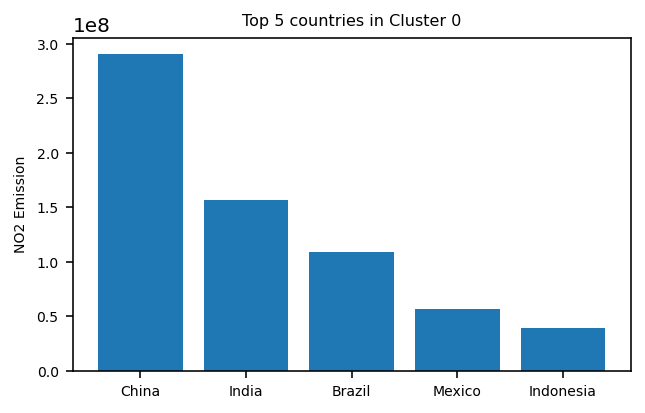

In [74]:
plt.figure(dpi=144, figsize=(5,3))
plt.bar(cluster0_top5['Country'], cluster0_top5['Emission'])
plt.title("Top 5 countries in Cluster 0", fontsize=8)
plt.ylabel("NO2 Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()


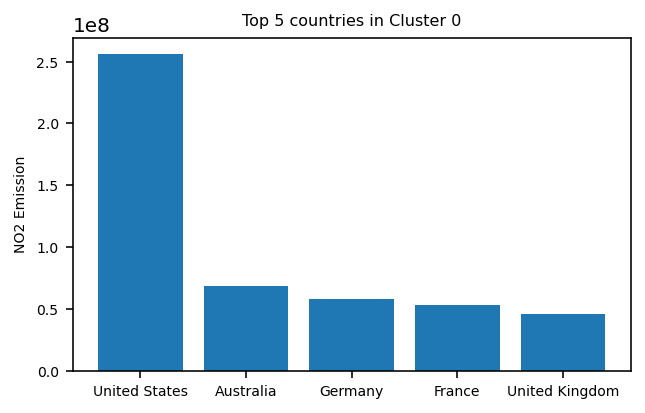

In [75]:
plt.figure(dpi=144, figsize=(5,3))
plt.bar(cluster1_top5['Country'], cluster1_top5['Emission'])
plt.title("Top 5 countries in Cluster 0", fontsize=8)
plt.ylabel("NO2 Emission", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

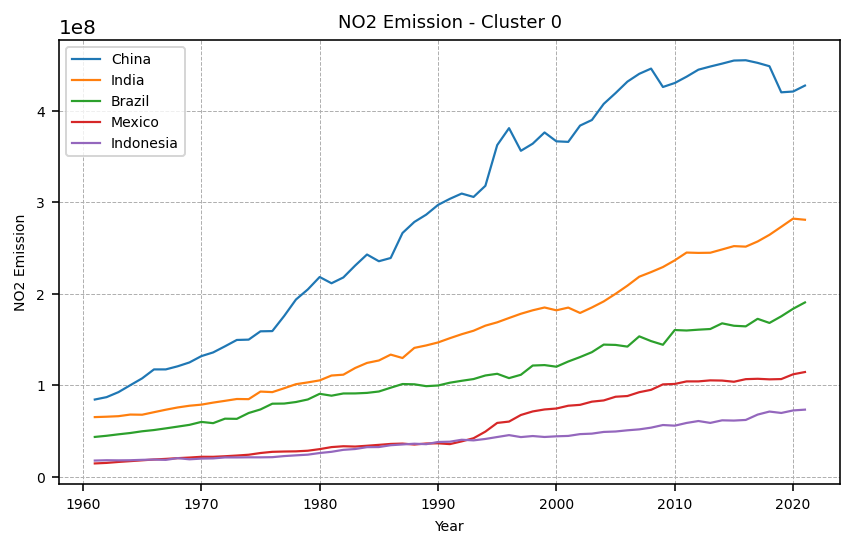

In [78]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster0_top5['Country']:
  country_df = cluster0_df[cluster0_df['Country']==country]
  plt.plot(country_df["Year"], country_df['Emission'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - Cluster 0", fontsize=9)
plt.show()


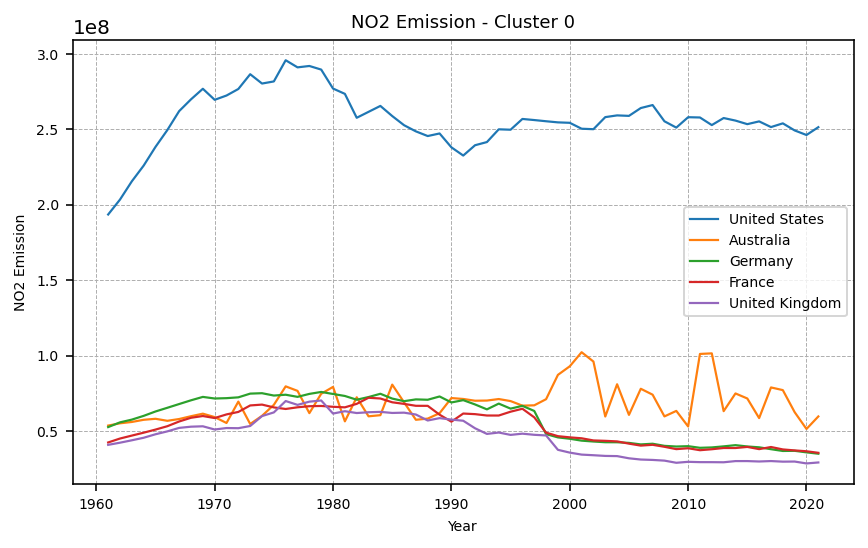

In [81]:
plt.figure(dpi=144, figsize=(7,4))
for country in cluster1_top5['Country']:
  country_df = cluster1_df[cluster1_df['Country']==country]
  plt.plot(country_df["Year"], country_df['Emission'], label=country,
           linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - Cluster 0", fontsize=9)
plt.show()